In [1]:
# Import used packages
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import random
import os
import math
from torchvision.transforms import ToTensor
import io
import time
import random
from utils import *
from datasets import *
import sys
import shutil

device = torch.device("cuda:2")

import time
start_time = time.time()

In [2]:
# Hyperparameter setup
num_iteration = 50000    # Number of interactions between airline and agents
conservative_prob = 0.3   # Proportion of decision agents that are conservative
use_bet = True            # Whether the betting mechanism is used


lr = 4e-4                 # Learning rate of forecaster
bias_minimizer = 'swap'   # Bias minimizer of forecaster, can choose swap, none, naive, avg
num_bins = 40             # Choice of K for swap regret minimizer

In [3]:
run_label = 0

log_directory = '/data/mechanism-uncertainty/flight'
while True:
    log_dir = '%s/usebet=%r-bias=%s-consprob=%.2f-clr=%.5f-num_bins=%d-run=%d' % \
        (log_directory, use_bet, bias_minimizer, conservative_prob, lr, num_bins, run_label)
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)
        break
    run_label += 1
print("Run number = %d" % run_label)

writer = SummaryWriter(log_dir)
global_iteration = 0   

Run number = 3


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
dataset = FlightDataset(device, batch_size=1, max_train_size=num_iteration) 

In [5]:
# Very simple classifier
class Classifier(nn.Module):
    def __init__(self, x_dim, out_dim=1, size=8):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(x_dim, size)
        self.fc2 = nn.Linear(size, out_dim)
        
    def forward(self, x):
        fc = F.leaky_relu(self.fc1(x))
        fc = self.fc2(fc)
        return fc

In [6]:
model_f = Classifier(dataset.x_dim).to(device)
model_c = Classifier(dataset.x_dim).to(device)

model_bias = minimizers[bias_minimizer](vmin=-0.1, vmax=0.1, num_step=num_bins)
optim_step = optim.Adam(list(model_c.parameters()) + list(model_f.parameters()), lr=lr)

torch.Size([1]) torch.Size([1]) torch.Size([1])
tensor([0.2000], dtype=torch.float64) tensor([0.1000], dtype=torch.float64) tensor([1.], dtype=torch.float64)


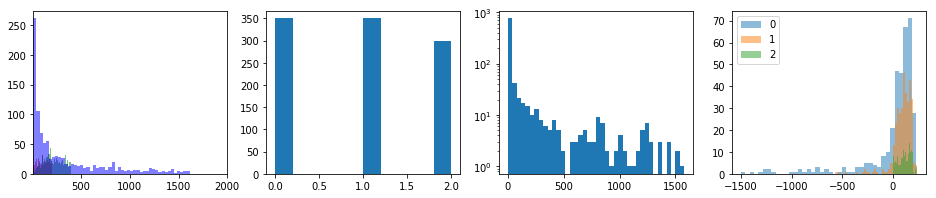

tensor(103502.8070, dtype=torch.float64)

In [8]:
bet_revenue_cum = 0.0
ticket_revenue_cum = 0.0
agent_utility_cum = torch.zeros(3).to(device)
agent_count = torch.zeros(3).to(device)

def evaluate_bets(pred, cost, labels, writer, debug=False):
    global bet_revenue_cum
    global ticket_revenue_cum
    
    if debug:
        plt.figure(figsize=(16, 3))
        print(pred.shape, cost.shape, labels.shape)
        print(pred, cost, labels)
        
    # Simulate agents making decisions
    with torch.no_grad():
        # Compute the expected loss under the predicted probability 
        num_person = 1000
        num_ticket = 300

        r_alt = torch.rand(size=(num_person,), dtype=pred.dtype).to(pred.device) * 200.0
        r_trip = torch.rand_like(r_alt) * 400.0
        r_trip = torch.max(r_alt, r_trip)
        c_delay = ((4.0 + torch.rand_like(r_alt) * 5.0)).exp() / 5.0

        if debug:
            plt.subplot(1, 4, 1)
            plt.hist(r_alt, bins=50, color='r', alpha=0.5)
            plt.hist(r_trip, bins=50, color='g', alpha=0.5)
            plt.hist(c_delay, bins=50, color='b', alpha=0.5)
            plt.xlim((10, 2000))
    
        max_price_naive = r_trip - r_alt 
        if use_bet:
            max_price_conservative = r_trip - r_alt - (pred + cost) * c_delay
        else:
            max_price_conservative = r_trip - r_alt - c_delay
        max_price_trustful = r_trip - r_alt - pred * c_delay 
        
        agent_type = torch.zeros_like(r_alt, dtype=torch.int)  # Agent type = 0: naive, 1: trustful, 2: conservative,
        trustful_prob = 0.5 * (1.0 - conservative_prob)
        agent_type[:int(num_person * trustful_prob)] = 1
        agent_type[-int(num_person * conservative_prob):] = 2
        agent_type = agent_type[torch.randperm(num_person)]
        
        if debug:
            plt.subplot(1, 4, 2)
            plt.hist(agent_type)

        max_price = max_price_naive * (agent_type == 0) + max_price_conservative * (agent_type == 2) + max_price_trustful * (agent_type == 1)
        if use_bet:
            bet_naive = torch.zeros_like(r_alt)
            bet_trustful = torch.zeros_like(r_alt)
            bet_conservative = c_delay  
            bet = bet_naive * (agent_type == 0) + bet_conservative * (agent_type == 2) + bet_trustful * (agent_type == 1)
        else:
            bet = torch.zeros_like(r_alt)
            
        final_price, _ = torch.sort(max_price)
        final_price = final_price[-num_ticket-1]
        
        if debug:
            plt.subplot(1, 4, 3)
            plt.hist(bet, bins=40)
            plt.yscale('log')

        total_bet = bet.sum() 
        
        ticket_revenue = final_price * num_ticket
        bet_revenue = total_bet * (pred - labels) + total_bet.abs() * cost 
        
        ticket_revenue_cum += ticket_revenue.sum()
        bet_revenue_cum += bet_revenue.sum()
        
        agent_buy = max_price > final_price
        
        agent_utility_buy = r_trip - final_price - labels * c_delay + bet * (labels - pred) - bet.abs() * cost 
        for agent_i in range(3):
            utilities = torch.cat([agent_utility_buy[(agent_type==agent_i) & agent_buy], r_alt[(agent_type==agent_i) & (~agent_buy)]])
            agent_utility_cum[agent_i] += utilities.sum()
            agent_count[agent_i] += (agent_type == agent_i).type(torch.int).sum()
            
            if debug:
                plt.subplot(1, 4, 4)
                plt.hist(utilities, bins=40, alpha=0.5, label='%d' % agent_i)
        if debug:
            plt.legend()
            plt.show()

        for agent_i in range(3):
            writer.add_scalar('utility_%d_cum' % agent_i, agent_utility_cum[agent_i] / (1e-5 + agent_count[agent_i]), global_iteration)
    return total_bet
             
# Code for plotting and debugging evaluate_bets with dummy inputs
delay_prob = torch.from_numpy(np.array([0.2]))
y = torch.from_numpy(np.array([1.0]))
cost = torch.from_numpy(np.array([0.1])) 
evaluate_bets(delay_prob, cost, y, writer, debug=True)

In [ ]:
for iteration in range(num_iteration):
    inputs, labels, extra = dataset.train_batch()
    optim_step.zero_grad()

    pred = model_f(inputs)
    cost = model_c(inputs)
    cost_bias = model_bias.get_pred()
    writer.add_scalar('bias', cost_bias, global_iteration)

    with torch.no_grad():
        bet = evaluate_bets(pred=pred.flatten(), cost=cost.flatten() + cost_bias, labels=labels.flatten(), writer=writer).view(-1, 1)
        
    writer.add_scalar('revenue_bet_cum', bet_revenue_cum / (1 + iteration), global_iteration)
    writer.add_scalar('revenue_ticket_cum', ticket_revenue_cum / (1 + iteration), global_iteration)
    writer.add_scalar('revenue_total', (bet_revenue_cum + ticket_revenue_cum) / (1 + iteration), global_iteration)

    if bias_minimizer == 'avg':
        model_bias.set_outcome(a=(bet * (labels - pred) - bet.abs() * cost).detach().item(), b=-bet.abs().detach().item())
    else:
        model_bias.set_outcome(a=((bet * (labels - pred) - bet.abs() * cost) / (1e-10 + bet.abs().sqrt())).detach().item(), b=-bet.abs().sqrt().detach().item())

    # Train based only on the new data
    c_loss = (bet * (labels - pred.detach()) - bet.abs() * cost).pow(2).mean()
    f_loss = (labels - pred).pow(2).mean()
    loss_all = f_loss + c_loss
    loss_all.backward()
    optim_step.step()

    writer.add_scalar('loss_c', c_loss, global_iteration)
    writer.add_scalar('loss_f', f_loss, global_iteration)
    writer.add_scalar('avg_cost', cost.mean(), global_iteration)
    writer.add_scalar('avg_pred', pred.mean(), global_iteration)
    writer.add_scalar('avg_label', labels.mean(), global_iteration)
    
    global_iteration += 1

    if iteration % (num_iteration // 10) == 0:
        print("Running iteration %d, time_elapsed=%.2f" % (iteration, time.time() - start_time))

Running iteration 0, time_elapsed=96.84
Running iteration 10000, time_elapsed=176.91
